## XGBoost

### Import Libraries

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
color_pal = sns.color_palette()
sns.set()
plt.style.use('fivethirtyeight')

### Loading Data

In [137]:
df = pd.read_csv('traffic.csv')
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)
df.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


### Vehicles over times plot

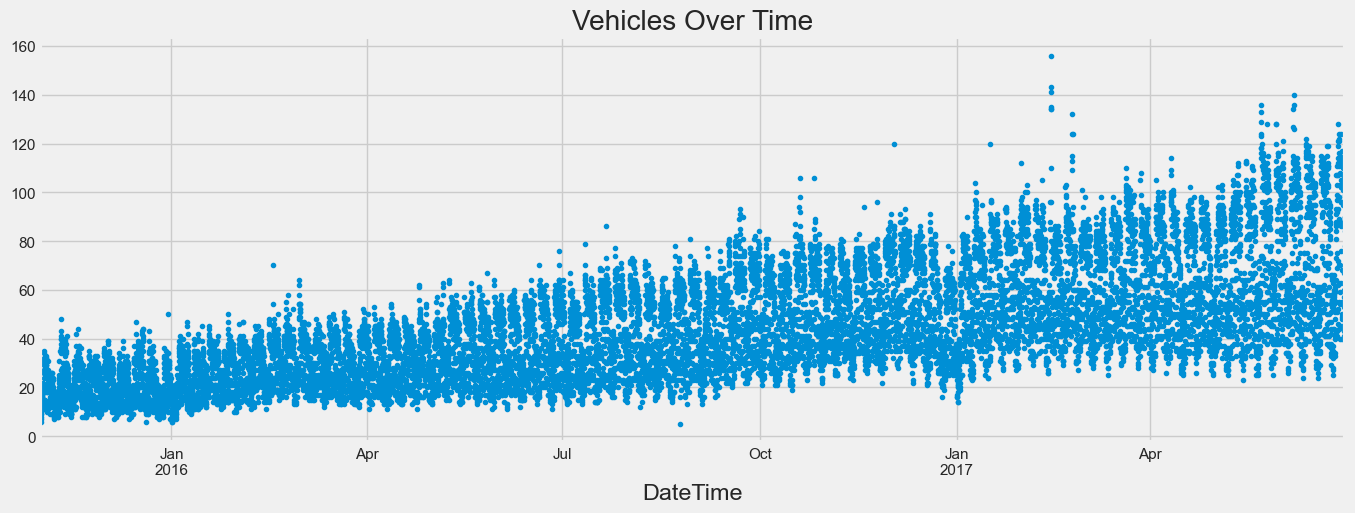

In [138]:
j_1 = df[df['Junction']==1] # Vehicles volume in Junction 1
j_1['Vehicles'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Vehicles Over Time')
plt.show()

### Time Series Cross Validation

In [139]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=24*120*1, gap=24)
j_1 = j_1.sort_index()

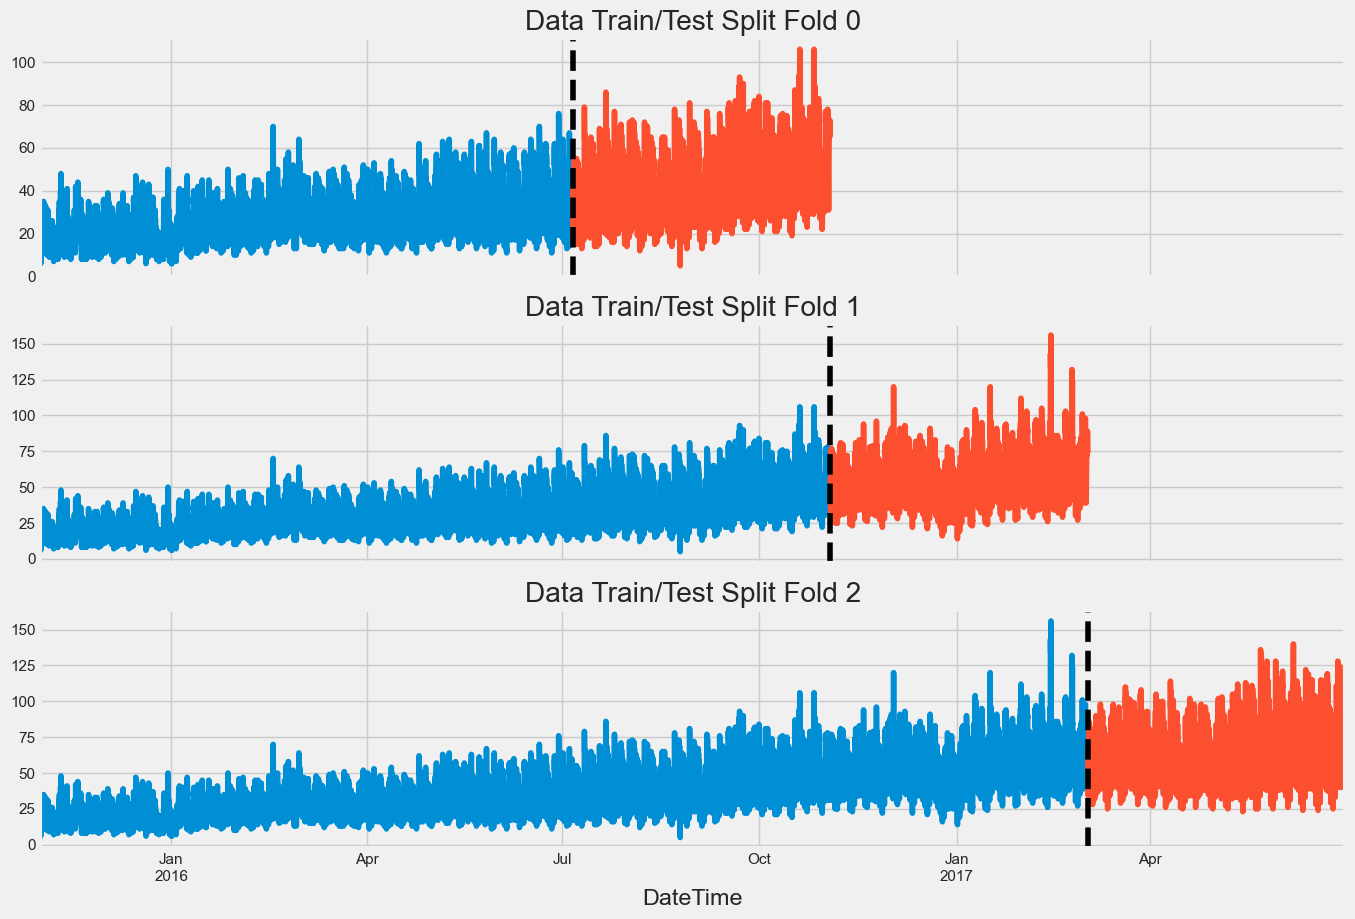

In [140]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(j_1):
    train = j_1.iloc[train_idx]
    test = j_1.iloc[val_idx]
    train['Vehicles'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Vehicles'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Week of data plot

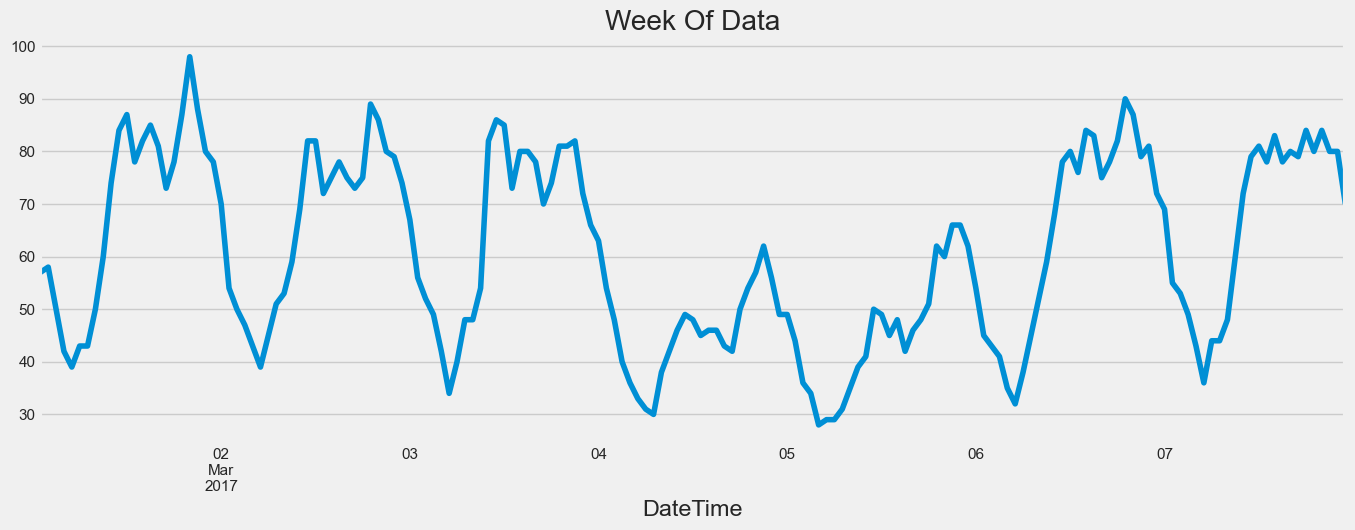

In [141]:
j_1['Vehicles'].loc[(j_1.index > '03-01-2017') & (j_1.index < '03-08-2017')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

### Feature Creation

In [142]:
def create_features(j_1):
    """
    Create time series features based on time series index.
    """
    j_1 = j_1.copy()
    j_1['hour'] = j_1.index.hour
    j_1['dayofweek'] = j_1.index.dayofweek
    j_1['quarter'] = j_1.index.quarter
    j_1['month'] = j_1.index.month
    j_1['year'] = j_1.index.year
    j_1['dayofyear'] = j_1.index.dayofyear
    j_1['dayofmonth'] = j_1.index.day
    j_1['weekofyear'] = j_1.index.isocalendar().week
    return j_1

j_1 = create_features(j_1)

### Lag Features

In [143]:
# def add_lags(j_1):
#     target_map = j_1['Vehicles'].to_dict()
#     j_1['lag1'] = (j_1.index - pd.Timedelta('182 days')).map(target_map)
#     j_1['lag2'] = (j_1.index - pd.Timedelta('364 days')).map(target_map)
#     return j_1

In [144]:
# j_1 = add_lags(j_1)

In [145]:
j_1.head()

,Junction,Vehicles,ID,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,,,
2015-11-01 00:00:00,1,15,20151101001,0,6,4,11,2015,305,1,44
2015-11-01 01:00:00,1,13,20151101011,1,6,4,11,2015,305,1,44
2015-11-01 02:00:00,1,10,20151101021,2,6,4,11,2015,305,1,44
2015-11-01 03:00:00,1,7,20151101031,3,6,4,11,2015,305,1,44
2015-11-01 04:00:00,1,9,20151101041,4,6,4,11,2015,305,1,44


In [146]:
j_1.tail()

,Junction,Vehicles,ID,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,,,
2017-06-30 19:00:00,1,105,20170630191,19,4,2,6,2017,181,30,26
2017-06-30 20:00:00,1,96,20170630201,20,4,2,6,2017,181,30,26
2017-06-30 21:00:00,1,90,20170630211,21,4,2,6,2017,181,30,26
2017-06-30 22:00:00,1,84,20170630221,22,4,2,6,2017,181,30,26
2017-06-30 23:00:00,1,78,20170630231,23,4,2,6,2017,181,30,26


In [147]:
j_1['Vehicles'].unique

<bound method Series.unique of DateTime
2015-11-01 00:00:00     15
2015-11-01 01:00:00     13
2015-11-01 02:00:00     10
2015-11-01 03:00:00      7
2015-11-01 04:00:00      9
                      ... 
2017-06-30 19:00:00    105
2017-06-30 20:00:00     96
2017-06-30 21:00:00     90
2017-06-30 22:00:00     84
2017-06-30 23:00:00     78
Name: Vehicles, Length: 14592, dtype: int64>

## Model Training

In [148]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*120*1, gap=24)
j_1 = j_1.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(j_1):
    train = j_1.iloc[train_idx]
    test = j_1.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'month', 'year', 'dayofyear', 'dayofmonth','weekofyear']
    TARGET = 'Vehicles'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:30.05273	validation_1-rmse:47.47047


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:05:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12.36001	validation_1-rmse:29.08899
[200]	validation_0-rmse:6.56759	validation_1-rmse:21.12116
[300]	validation_0-rmse:4.81859	validation_1-rmse:17.65425
[400]	validation_0-rmse:4.26225	validation_1-rmse:15.89192
[500]	validation_0-rmse:4.00819	validation_1-rmse:15.27398
[600]	validation_0-rmse:3.86439	validation_1-rmse:15.15472
[700]	validation_0-rmse:3.75674	validation_1-rmse:15.06692
[800]	validation_0-rmse:3.66831	validation_1-rmse:15.00489
[900]	validation_0-rmse:3.59844	validation_1-rmse:14.96338
[999]	validation_0-rmse:3.54479	validation_1-rmse:14.91308
[0]	validation_0-rmse:36.55584	validation_1-rmse:59.27228
[100]	validation_0-rmse:15.53221	validation_1-rmse:40.06634
[200]	validation_0-rmse:8.31608	validation_1-rmse:32.59818


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:05:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[300]	validation_0-rmse:5.99611	validation_1-rmse:29.73700
[400]	validation_0-rmse:5.13274	validation_1-rmse:28.87149
[500]	validation_0-rmse:4.77314	validation_1-rmse:28.61110
[600]	validation_0-rmse:4.58349	validation_1-rmse:28.42593
[700]	validation_0-rmse:4.44084	validation_1-rmse:28.36473
[792]	validation_0-rmse:4.33751	validation_1-rmse:28.35940
[0]	validation_0-rmse:43.16783	validation_1-rmse:70.08517
[100]	validation_0-rmse:18.87553	validation_1-rmse:35.02918
[200]	validation_0-rmse:10.56172	validation_1-rmse:21.73788


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:05:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[300]	validation_0-rmse:7.60398	validation_1-rmse:16.36077
[400]	validation_0-rmse:6.49095	validation_1-rmse:13.90139
[500]	validation_0-rmse:5.97591	validation_1-rmse:12.82031
[600]	validation_0-rmse:5.68906	validation_1-rmse:12.25675
[700]	validation_0-rmse:5.49346	validation_1-rmse:11.96461
[800]	validation_0-rmse:5.34875	validation_1-rmse:11.65368
[900]	validation_0-rmse:5.22757	validation_1-rmse:11.42041
[999]	validation_0-rmse:5.13106	validation_1-rmse:11.24420


In [149]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 18.1694
Fold scores:[np.float64(14.912952891377001), np.float64(28.350901583644017), np.float64(11.244198468834627)]


In [150]:
from sklearn.model_selection import GridSearchCV

j_1 = create_features(j_1)

# Define features and target
FEATURES = ['hour', 'dayofweek', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
TARGET = 'Vehicles'

# Prepare data
X_all = j_1[FEATURES]
y_all = j_1[TARGET]

# Initialize XGBoost model
reg = xgb.XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',  # Updated from reg:linear
    early_stopping_rounds=50
)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Set up TimeSeriesSplit for cross-validation
tss = TimeSeriesSplit(n_splits=3, test_size=24*120*1, gap=24)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Optimize for RMSE
    cv=tss,  # Use TimeSeriesSplit for CV
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(
    X_all, y_all,
    eval_set=[(X_all, y_all)],
    verbose=100
)

# Print best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best RMSE score: {-grid_search.best_score_}')

# Get the best model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[0]	validation_0-rmse:22.21647
[100]	validation_0-rmse:6.40340
[200]	validation_0-rmse:5.55517
[300]	validation_0-rmse:5.19082
[400]	validation_0-rmse:4.96228
[500]	validation_0-rmse:4.80511
[600]	validation_0-rmse:4.67631
[700]	validation_0-rmse:4.55275
[800]	validation_0-rmse:4.45919
[900]	validation_0-rmse:4.38763
[999]	validation_0-rmse:4.32785
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Best RMSE score: 17.93296718597412


In [151]:
# j_1 = create_features(j_1)

# FEATURES = ['hour', 'dayofweek', 'month', 'year', 'dayofyear', 'dayofmonth','weekofyear']
# TARGET = 'Vehicles'

# X_all = j_1[FEATURES]
# y_all = j_1[TARGET]

# reg = xgb.XGBRegressor(base_score=0.5,
#                        booster='gbtree',
#                        n_estimators=500,
#                        objective='reg:linear',
#                        max_depth=3,
#                        learning_rate=0.01)
# reg.fit(X_all, y_all,
#         eval_set=[(X_all, y_all)],
#         verbose=100)

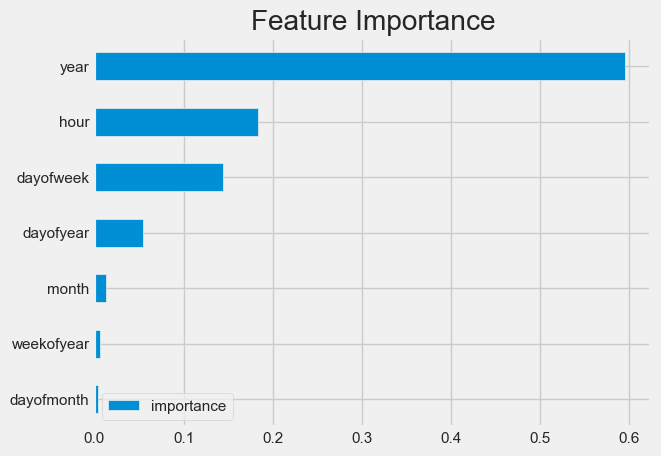

In [152]:
fi = pd.DataFrame(data=best_model.feature_importances_,
             index=best_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

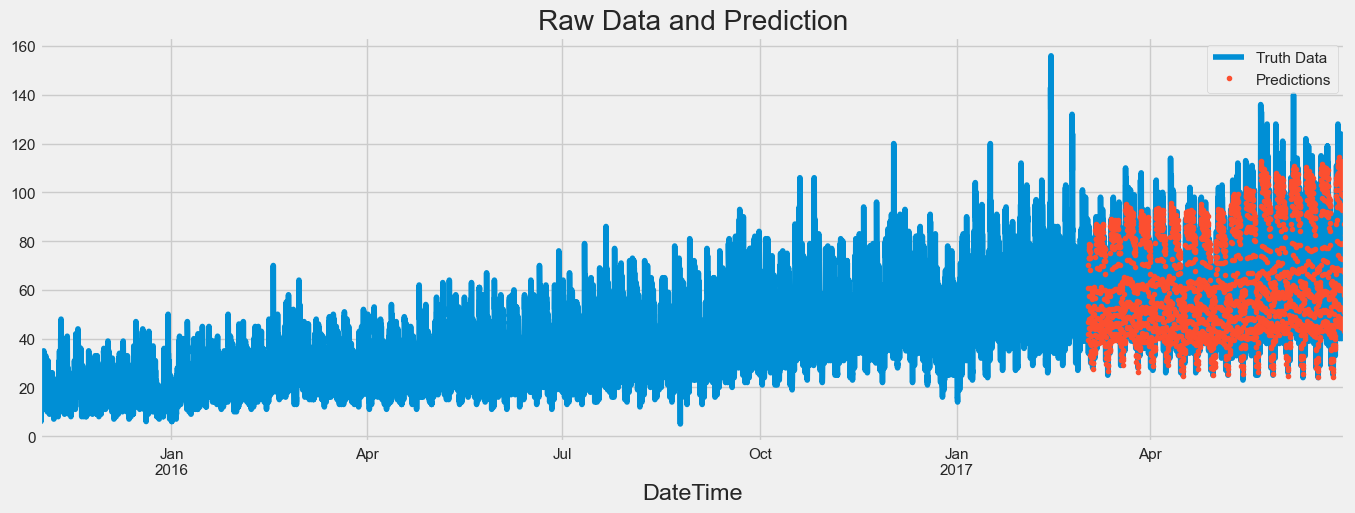

In [153]:
# Forecast on Test
test['prediction'] = best_model.predict(X_test)

# Reset index of both dataframes before merging to avoid index mismatch
j_1 = j_1.reset_index()
test = test.reset_index()

# Merge based on shared columns, if any, or on the 'DateTime' column if it exists in both
# Assuming 'DateTime' exists in both:
j_1 = pd.merge(j_1, test[['DateTime', 'prediction']], on='DateTime', how='left')

# Set 'DateTime' back as index if needed
j_1 = j_1.set_index('DateTime')

ax = j_1[['Vehicles']].plot(figsize=(15, 5))
j_1['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

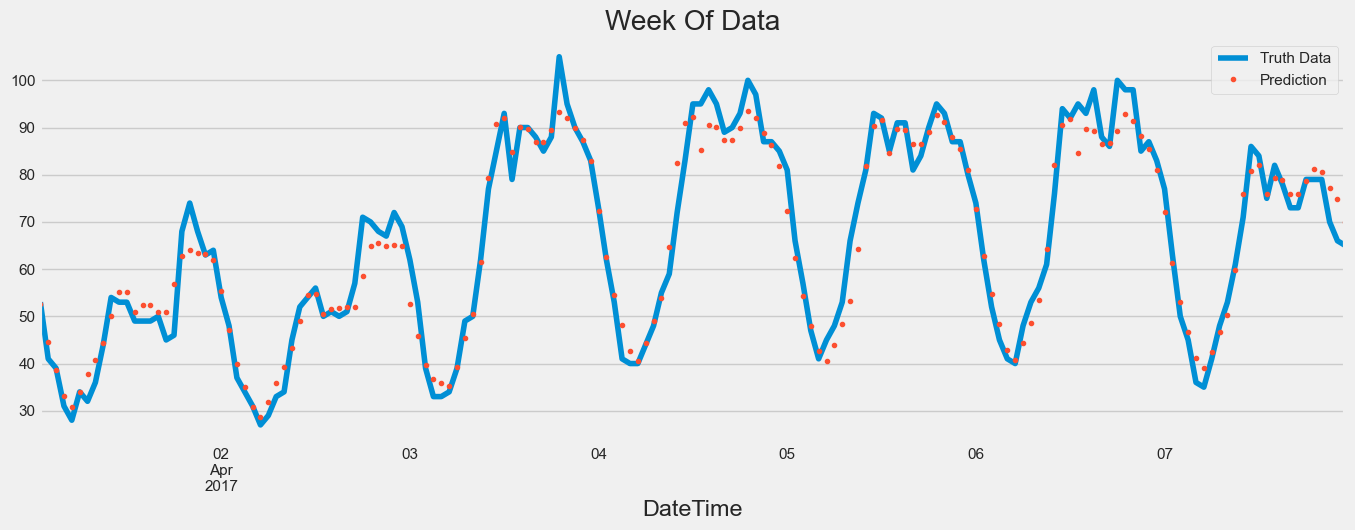

In [154]:
ax = j_1.loc[(j_1.index > '04-01-2017') & (j_1.index < '04-08-2017')]['Vehicles'] \
    .plot(figsize=(15, 5), title='Week Of Data')
j_1.loc[(j_1.index > '04-01-2017') & (j_1.index < '04-08-2017')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Model Evaluation

In [155]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test['Vehicles'], test['prediction'])
mse = mean_squared_error(test['Vehicles'], test['prediction'])
rmse = np.sqrt(mse)
r2 = r2_score(test['Vehicles'], test['prediction'])

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 3.6918
MSE: 26.3304
RMSE: 5.1313
R² Score: 0.9532


### Calculate Error

In [156]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test['DateTime']
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-05-30 22:00:00    44.379997
2017-05-01 16:00:00    38.516563
2017-06-06 18:00:00    32.644638
2017-05-01 13:00:00    31.593704
2017-06-06 17:00:00    29.388641
2017-06-06 19:00:00    25.034103
2017-05-22 11:00:00    24.865417
2017-03-13 12:00:00    24.499969
2017-03-13 11:00:00    24.323044
2017-03-08 10:00:00    24.040382
Name: error, dtype: float64

In [157]:
j_1.index.max()

Timestamp('2017-06-30 23:00:00')

In [158]:
# Create future dataframe
future = pd.date_range(j_1.index.max(),'2017-8-01', freq='1h')
future_j_1 = pd.DataFrame(index=future)
future_j_1['isFuture'] = True
j_1['isFuture'] = False
df_and_future_1 = pd.concat([j_1, future_j_1])
df_and_future_1 = create_features(df_and_future_1)
# df_and_future_1 = add_lags(df_and_future_1)

### Predict the future

In [159]:
future_w_features_1 = df_and_future_1.query('isFuture').copy()

In [160]:
future_w_features_1['pred'] = best_model.predict(future_w_features_1[FEATURES])

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


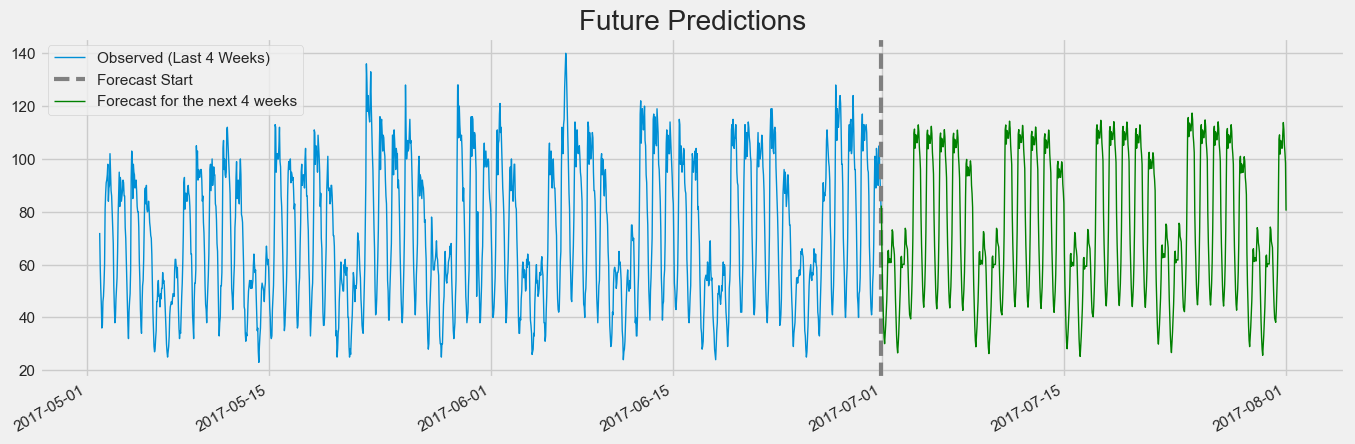

In [161]:
plt.plot(j_1['Vehicles'][-24*60:], label='Observed (Last 4 Weeks)', ms=1, lw=1)
plt.axvline(x=j_1.index.max(), color='gray', linestyle='--', label='Forecast Start', ms=1, lw=3)
future_w_features_1['pred'].plot(figsize=(15, 5),
                               color='green',
                               ms=1,
                               lw=1,
                               title='Future Predictions', label='Forecast for the next 4 weeks')
plt.legend()
plt.show()